In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_statevars_et
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
#print(bmi_cfe)
print(bmi_cfe_statevars_et)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_statevars_et' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_statevars_et.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
# cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
# cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
# cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT/usgs_config.json')



initialized 100
                         Date    Flow  validity
0   2015-10-01 04:00:00+00:00  1.9700       1.0
1   2015-10-01 05:00:00+00:00  1.9675       1.0
2   2015-10-01 06:00:00+00:00  1.9500       1.0
3   2015-10-01 07:00:00+00:00  1.9225       1.0
4   2015-10-01 08:00:00+00:00  1.8925       1.0
..                        ...     ...       ...
739 2015-10-31 23:00:00+00:00  1.6700       1.0
740 2015-11-01 00:00:00+00:00  1.6600       1.0
741 2015-11-01 01:00:00+00:00  1.6600       1.0
742 2015-11-01 02:00:00+00:00  1.6550       1.0
743 2015-11-01 03:00:00+00:00  1.6500       1.0

[744 rows x 3 columns]
USGS station ID 01123000


                 time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0      10/1/2015 0:00           0.0       0.0  294.058  0.014050  2.8084   
1      10/1/2015 1:00           0.0       0.0  292.598  0.012694  1.9296   
2      10/1/2015 2:00           0.0       0.0  291.122  0.011326  1.0514   
3      10/1/2015 3:00           0.0       0.0  289.690  0.009996  0.1772   
4      10/1/2015 4:00           0.0       0.0  288.924  0.009542 -0.3594   
..                ...           ...       ...      ...       ...     ...   
739  10/31/2015 19:00           0.0       0.0  283.832  0.004422  2.0008   
740  10/31/2015 20:00           0.0       0.0  283.632  0.004590  1.8150   
741  10/31/2015 21:00           0.0       0.0  283.442  0.004756  1.6314   
742  10/31/2015 22:00           0.0       0.0  282.572  0.004974  1.4624   
743  10/31/2015 23:00           0.0       0.0  281.676  0.005184  1.2984   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -4.0768   99421.66    0.000  399.016  
1

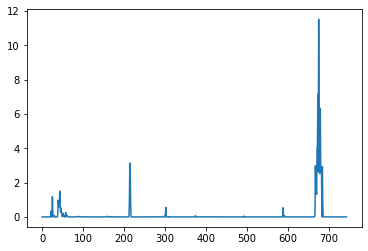

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

In [6]:
# Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow'))*50 #need array for EnKf function. should get this when initialize.  
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_analysis.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    soil_storage_avail = cfe_analysis.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_analysis.get_value('surface_runoff_depth_m')
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    
    #For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    state_transition_runoff       = enkf.get_value('surface_runoff_depth_m')
    print("State Trans Runoff", state_transition_runoff)
    print("CFE Open", outflow)
    print("EnKF", outflow_enkf)
    
#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('surface_runoff_depth_m', state_transition_runoff) 
    cfe_analysis.update() #get new streamflow value based on state var change
    
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('surface_runoff_depth_m')
   
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('surface_runoff_depth_m', cfe_updated_everything_runoff)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
# usgs.finalize()
# enkf.finalize()

[-0.04716005]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.014465502346721011
EnKF [37.14087329]
[-0.07719436]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.013545609947676045
EnKF [60.7805787]
[-0.07363734]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.012687304315028576
EnKF [57.97940851]
[-0.0542037]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.011886084500209995
EnKF [42.6821719]
[-0.04342637]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.011137824558037045
EnKF [34.19477469]
[-0.04409265]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.010438736771191615
EnKF [34.71873143]
[-0.05294935]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.009785339131660591
EnKF [41.68799915]
[-0.06622858]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.009174426509658572
EnKF [52.14130077]
[-0.05004095]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.008603045026367263
EnKF [39.39962

[-0.06242849]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.08982085790354509
EnKF [49.21552636]
[-0.03356433]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.08882561535687077
EnKF [26.540034]
[-0.04423158]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.08744714316476726
EnKF [34.92152171]
[-0.04949112]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.08924910305761048
EnKF [39.04409904]
[-0.04528327]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.09136687502527158
EnKF [35.72458178]
[-0.0359052]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.09283120468091895
EnKF [28.35287374]
[-0.04429976]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.10466796664099713
EnKF [35.01012287]
[-0.0380098]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.117873528080569
EnKF [30.06467503]
[-0.0579424]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.12847743877644432
EnKF [45.68090068]
[-0.0221

[-0.04100107]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05645034859343673
EnKF [32.32888015]
[-0.0077238]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.056300927657494185
EnKF [6.119751]
[-0.04477009]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.055767790758721056
EnKF [35.29920315]
[-0.04020122]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05494761577307903
EnKF [31.71640012]
[-0.0573601]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05391804153737272
EnKF [45.19270628]
[-0.04578545]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05274074613845816
EnKF [36.08254627]
[-0.01264104]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05146423824531154
EnKF [10.00082602]
[-0.04061641]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.05012629394032392
EnKF [32.01492447]
[-0.03182265]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.11251260821420991
EnKF [25.169714]
[-0.04

Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.018286725613784468
EnKF [37.95142615]
[-0.02705908]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.01788758348114133
EnKF [21.31788807]
[-0.03887294]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.017498572354947162
EnKF [30.6192675]
[-0.03560492]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.017119273775343943
EnKF [28.0430369]
[-0.02894169]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.01674929664058707
EnKF [22.79880103]
[-0.03845306]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.016388275150884674
EnKF [30.28434265]
[-0.05088964]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.01603586690583412
EnKF [40.07999131]
[-0.03611081]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.017101279350842248
EnKF [28.44290102]
[-0.04599445]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.01701848691168021
EnKF [36.22299488]
[-0.04166362

[-0.04996995]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.016639015602010317
EnKF [39.35177882]
[-0.04507845]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.016274739813361513
EnKF [35.50182234]
[-0.01083928]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.01592028700100563
EnKF [8.55018165]
[-0.03416797]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.015575205787941629
EnKF [26.91024781]
[-0.03237558]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.015239075762059299
EnKF [25.49693233]
[-0.03752329]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.014911505148235181
EnKF [29.55274386]
[-0.04671586]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.014592128649910167
EnKF [36.7876394]
[-0.04287542]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.014280605449559287
EnKF [33.7645193]
[-0.04610594]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.013976617357692083
EnKF [36.308120

[-0.02891003]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.011581158763434154
EnKF [22.77006629]
[-0.04231397]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.011327083212230235
EnKF [33.32098225]
[-0.03215431]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.011079511500234462
EnKF [25.32032879]
[-0.03197152]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.010838182103622718
EnKF [25.1759545]
[-0.04270273]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.010602848741333892
EnKF [33.62570134]
[-0.02669422]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.010373279529158156
EnKF [21.02347533]
[-0.04191041]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.010149256146095836
EnKF [33.00113926]
[-0.01157867]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.00993057302160393
EnKF [9.123434]
[-0.02897078]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.00971703654990508
EnKF [22.81588753

[-0.03240258]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.004836088549020526
EnKF [25.51182599]
[-0.05919102]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.0047130605970996725
EnKF [46.59880113]
[-0.01559999]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.004594258451603973
EnKF [12.28446982]
[-0.03822645]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.0044794745646587605
EnKF [30.09521742]
[-0.03293066]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.004368512396167788
EnKF [25.92729112]
[-0.04625544]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.00426118610542518
EnKF [36.41557225]
[-0.03803564]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.0041573201818608475
EnKF [29.94567624]
[-0.02827403]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.00405674903435786
EnKF [22.26063624]
[-0.0161606]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.003959316554398817
EnKF [12.72

[-0.04233458]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.023253211920936077
EnKF [33.34123077]
[-0.01768435]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.022481241226997253
EnKF [13.94066386]
[-0.03011917]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.021745892313653002
EnKF [23.73400477]
[-0.03765603]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.021045725193860373
EnKF [29.66114277]
[-0.03037926]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.020379176542057245
EnKF [23.93107281]
[-0.05769157]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.019744616535396515
EnKF [45.43351559]
[-0.03442594]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.019140391634701947
EnKF [27.11644958]
[-0.03956747]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.018564856369559225
EnKF [31.16044904]
[-0.03452179]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.018016396551316934
EnKF [27.19

[-0.04410394]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.11913426102074583
EnKF [34.86088973]
[-0.0562544]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.11489275128296754
EnKF [44.37509582]
[-0.06073437]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.11062971248194112
EnKF [47.97588599]
[-0.08917654]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.10695768881963424
EnKF [70.31587003]
[-0.05285948]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.10359287249263988
EnKF [41.69351786]
[-0.04257089]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.09992022954085279
EnKF [33.64274381]
[-0.06385651]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.09601789985094795
EnKF [50.3352875]
[-0.06820999]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.09247141614095869
EnKF [53.79423306]
[-0.03893139]
Overestimate runoff ratio 1
State Trans Runoff 0
CFE Open 0.08938379482577495
EnKF [30.74114735]
[-0

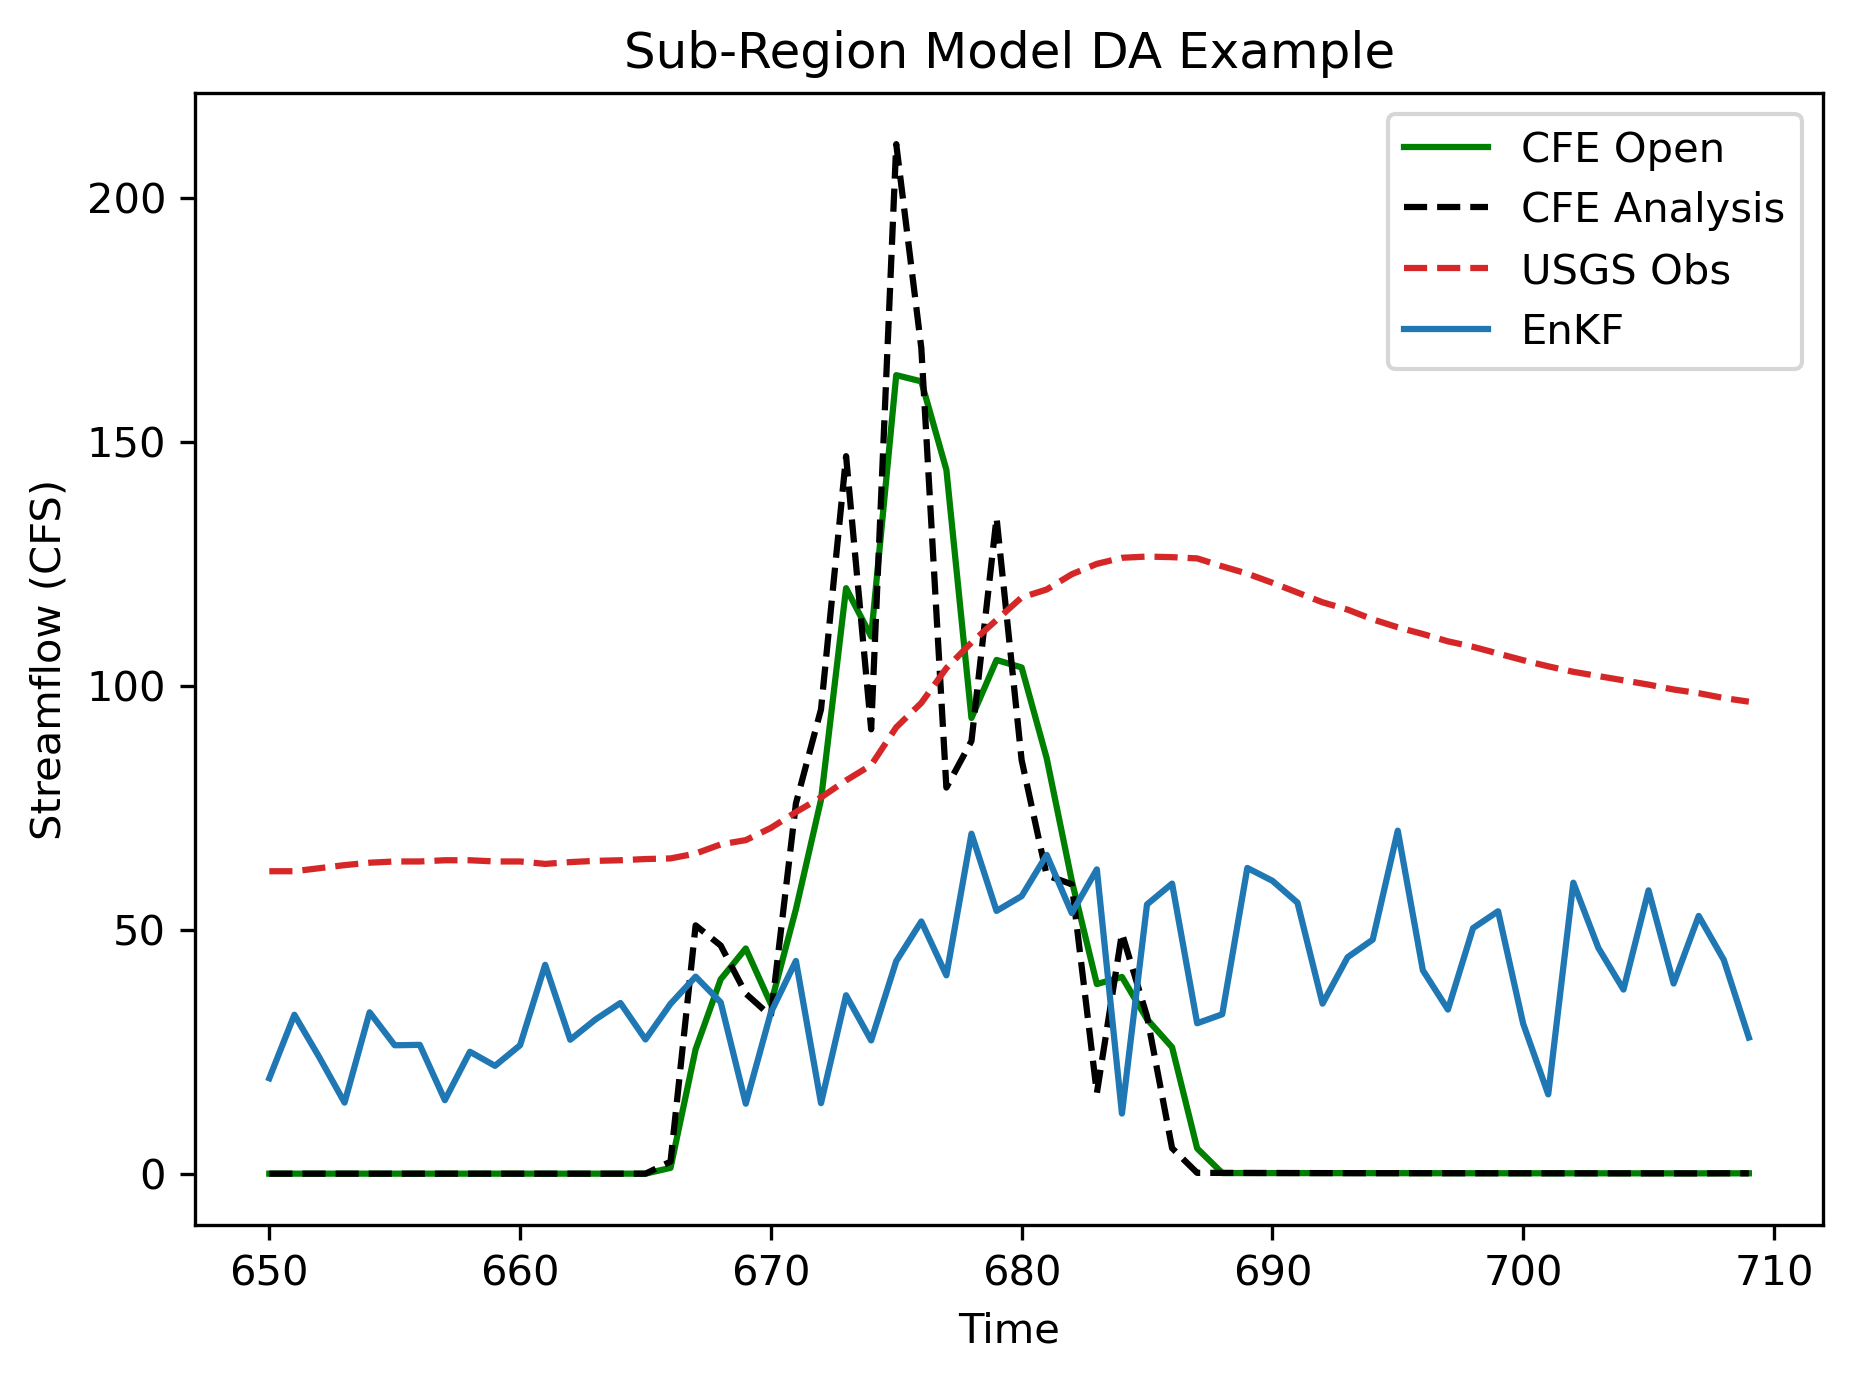

In [7]:
istart_plot=650
iend_plot=710
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.title('Sub-Region Model DA Example')
#plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
plt.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
plt.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
plt.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


In [8]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

